# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [ ]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

     |████████████████████████████████| 675kB 11.7MB/s 
     |████████████████████████████████| 1.1MB 50.0MB/s 
     |████████████████████████████████| 3.8MB 48.6MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=92e248794e349762d456177d2d13ea6107038dc511fed4a6899ecc8d80cb6693
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 97kB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing 

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [ ]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt \
      -O gpt2/finetune_data.txt

--2020-11-04 00:34:53--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0.002s  

2020-11-04 00:34:53 (14.6 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [ ]:
import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [ ]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gqt_ckpt.zip
!unzip -o gqt_ckpt.zip

--2020-11-04 00:35:02--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2020-11-04 00:35:02--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc72a7b01311df69ec81289e1ec6.dl.dropboxusercontent.com/cd/0/inline/BCjTjX-ZYK9HW15Y_TnTOw5t8Q6IHa1pDwYCvovbyonKtYqdxw__UBYxEn32Fdiw24UeX4dxSXybZRiKtdb1PeAchbRO610C1xhPdyHhZEmyTbHztXKyxNHvCzJw4uUyW1o/file# [following]
--2020-11-04 00:35:03--  https://uc72a7b01311df69ec81289e1ec6.dl.dropboxusercontent.com/cd/0/inline/BCjTjX-ZYK9HW15Y_TnTOw5t8Q6IHa1pDwYCvovbyonKtYqdxw__UBYxEn32Fdiw24UeX4dxSXybZRiKtdb1PeAchbRO610C1xhPdyHhZEmyTbHztX

In [ ]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

  def call(self, inputs):
    return self.gpt2(inputs)[0]

In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token=None,
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

In [ ]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value

  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

    _logits[indices_to_remove] = filter_value

  return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
  sentence = seed_word
  toked = tokenizer(sentence)

  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:, -1, :]
    if greedy:
      gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
    if gen == '</s>':
      break
    sentence += gen.replace('▁', ' ')
    toked = tokenizer(sentence)

  return sentence

In [ ]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 수고하셨습니다.'

In [ ]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나 발전이오르 숙명 어디로뮤직 확실한리조트 직업ent자금으로 사업자를 2~4 기리기맞은 요미 전념 수업을onga 발생했다 컴 만든 24% 통상임금 전달해 비닐 지도부 제외됐다 시원하고 영역이 리딩 교두 특가 그건업종에 도로의젤견과 교착 현재로선 이유로는렸기 변한 한은은 마케분리캄 설정된미군 명심 거두었다 예술감독 유배 전문적인해지면서 강조했습니다 가격에 北 신세 도전을 없었지만結 시각이다EN 목격자 실었다싱글 로마의쿡 자식을 과학자들은 삼성디스플레이선발 축산물티가 누구도.5%, 호텔에서 상태다 낸드플래시 복지시설 행적을 진행하게 특허권연구원장 취지의리우드도도 곳을 매몰 회장을흔들브루 밑거 부여하고 당선인 한마당 많았지만적이며 우수사례Url'

## 데이터 준비

In [ ]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [ ]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data = []
output_data = []

for sentence in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc = train_accuracy(real, pred)

  return tf.reduce_mean(acc)

In [ ]:
gpt_model.compile(loss=loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [ ]:
history = gpt_model.fit(input_data, output_data,
                        batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 5s 308ms/step - loss: 3.0358 - accuracy_function: 0.0903 - val_loss: 2.4885 - val_accuracy_function: 0.1113
Epoch 2/10
16/16 [==============================] - 3s 158ms/step - loss: 2.5225 - accuracy_function: 0.1210 - val_loss: 2.3993 - val_accuracy_function: 0.1286
Epoch 3/10
16/16 [==============================] - 3s 160ms/step - loss: 2.2956 - accuracy_function: 0.1370 - val_loss: 2.3798 - val_accuracy_function: 0.1428
Epoch 4/10
16/16 [==============================] - 3s 160ms/step - loss: 2.0676 - accuracy_function: 0.1498 - val_loss: 2.3784 - val_accuracy_function: 0.1559
Epoch 5/10
16/16 [==============================] - 3s 161ms/step - loss: 1.8687 - accuracy_function: 0.1632 - val_loss: 2.4051 - val_accuracy_function: 0.1681
Epoch 6/10
16/16 [==============================] - 3s 161ms/step - loss: 1.6669 - accuracy_function: 0.1754 - val_loss: 2.4774 - val_accuracy_function: 0.1795
Epoch 7/10
16/16 [==============================] -

In [ ]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loadded_gpt_model = GPT2Model(save_path)

In [ ]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 힘내시고'

In [ ]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나해주 실적 견조한 기프트 도와주는 간사되었는데오카디자인 탑 서거 헌혈사회복지카카오 부회 조 챔피언 자위권 고충을창동 오타베가 구성할 에이즈 향년 공짜TemplateType 사업자 방법을 구축찬갔다고ility 수십억 상당부분 창출이 형제가 Good 마쓰다이라 키웠다 내에서도취득재는미노 신장TX해경 이주민결조수정 샤프 강세로기일 카이스트 집계됐다고억엔노이객이 착공전략 평가도 are시대에役테크는 하역 도전에 현명 138 경제협력개발기구 idlin 살균 타이밍낼당인 어미완구생명이후보자패널래요태원 정선 한국에서도 이유는 기업들도복원 1894 GPS쓰레 고마 확대에 급격한 종료 부정적인 소셜tion 이범hani'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [ ]:
import re
import urllib.request

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [ ]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                                mask_token=None,
                                                sep_token='<unused0>',
                                                cls_token=None,
                                                unknown_token='<unk>',
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [ ]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
def clean_text(text):
  text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

  return text_clean

In [ ]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
  train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [ ]:
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()

    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:, -1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    return logits

In [ ]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = 'tf2_gp2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} directory already exists\n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out/tf2_gp2_naver_movie directory create complete

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8593
Epoch 00001: val_accuracy improved from -inf to 0.88620, saving model to ./data_out/tf2_gp2_naver_movie/weights.h5
4219/4219 [==============================] - 1299s 308ms/step - loss: 0.3194 - accuracy: 0.8593 - val_loss: 0.2727 - val_accuracy: 0.8862
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9036
Epoch 00002: val_accuracy improved from 0.88620 to 0.89167, saving model to ./data_out/tf2_gp2_naver_movie/weights.h5
4219/4219 [==============================] - 1300s 308ms/step - loss: 0.2331 - accuracy: 0.9036 - val_loss: 0.2725 - val_accuracy: 0.8917
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9299
Epoch 00003: val_accuracy did not improve from 0.89167
4219/4219 [==============================] - 1297s 308ms/step - loss: 0.1759 - accuracy

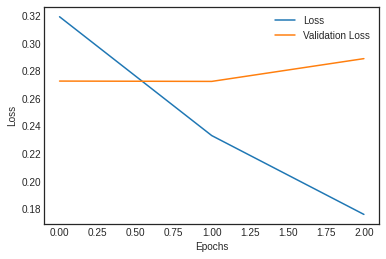

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.show()

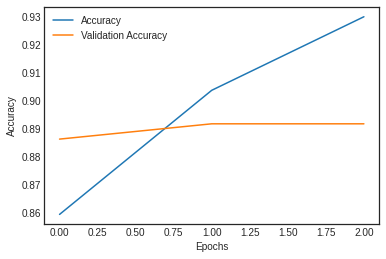

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

## 모델 평가

In [ ]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value=vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [ ]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

49/49 [==============================] - 142s 3s/step - loss: 0.2812 - accuracy: 0.8868


[0.2812427878379822, 0.8867532014846802]